# INTELIGENCIA ARTIFICIAL (1INF24)
Dr. Edwin Villanueva Talavera (ervillanueva@pucp.edu.pe)

# Entrenando y Seleccionando Modelos Simples de Regresión

In [1]:
# Cargar librerias y modulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]  # Por defecto las figuras se despliegan en 10 pulgadas de ancho y 8 de alto

from sklearn.linear_model import LinearRegression  # Para modelos de regresion lineal
from sklearn.linear_model import Ridge  # Ridge regression
from sklearn.linear_model import Lasso  # Lasso regression
from sklearn.linear_model import ElasticNet  # ElasticNet regression
from sklearn.neighbors import KNeighborsRegressor  # Knn regression
from sklearn.tree import DecisionTreeRegressor  # Decision Trees regression
from sklearn.svm import SVR  # Support Vector regression

from sklearn.model_selection import train_test_split  # Para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # Para partir la data en k-folds
from sklearn.model_selection import cross_val_score  # Para evaluar algoritmos en cross validacion

from sklearn.metrics import mean_squared_error, mean_absolute_error  # Para manejar metricas de desempeño
from sklearn.metrics import explained_variance_score  # Para hacer reportes de resultados de clasificacion
from sklearn.metrics import r2_score  # Para manejar matrices de confusion

Vamos a trabajar con el dataset Boston House Price dataset (<b>housings</b>)
https://www.kaggle.com/vikrishnan/boston-house-prices

/tmp/ipython-input-2-2828505118.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataset = pd.read_csv(filename, delim_whitespace = True, names = names)


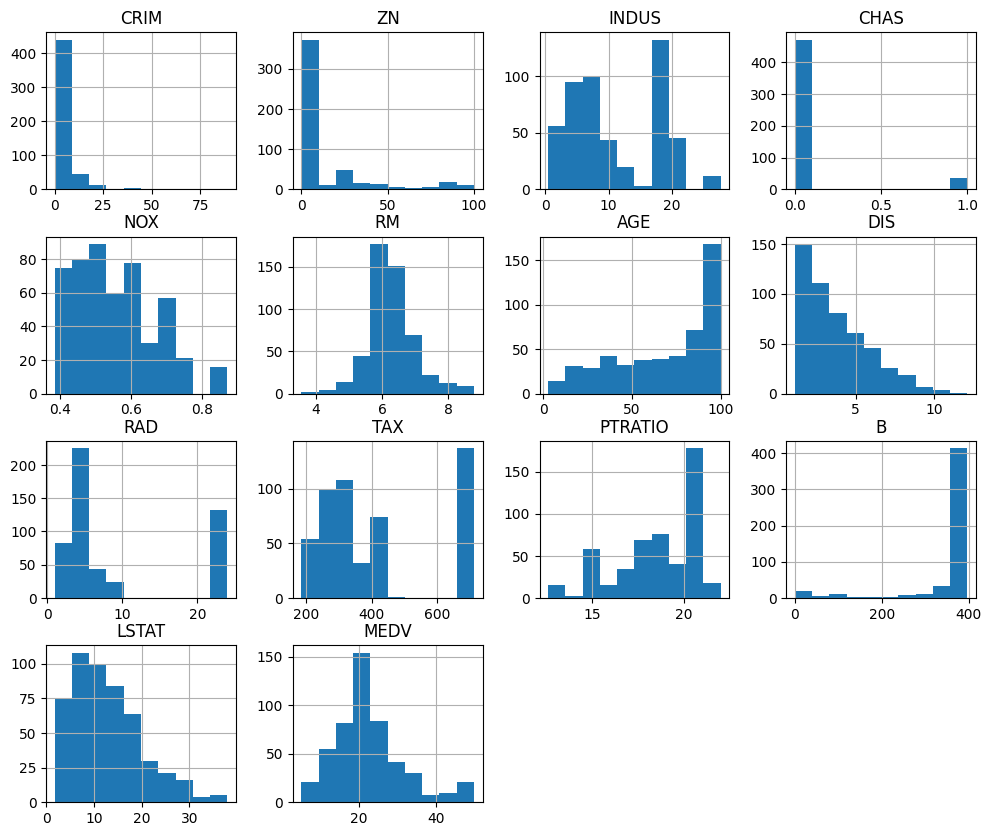

In [2]:
# Carga el dataset housing
filename = 'housing.csv'
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO','B', 'LSTAT', 'MEDV']
dataset = pd.read_csv(filename, delim_whitespace = True, names = names)

# Muestra la distribucion de las variables
dataset.hist(figsize = [12, 10])
plt.show()

In [3]:
dataset.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


La variable de interés (target) es MEDV.

#### Matriz de correlación

Se puede visualizar las correlaciones entre los diferentes pares de variables para entender la estructura de correlaciones. Regresión lineal puede tener pobre desempeño cuando las variables de entrada estan fuertemente correlacionadas.

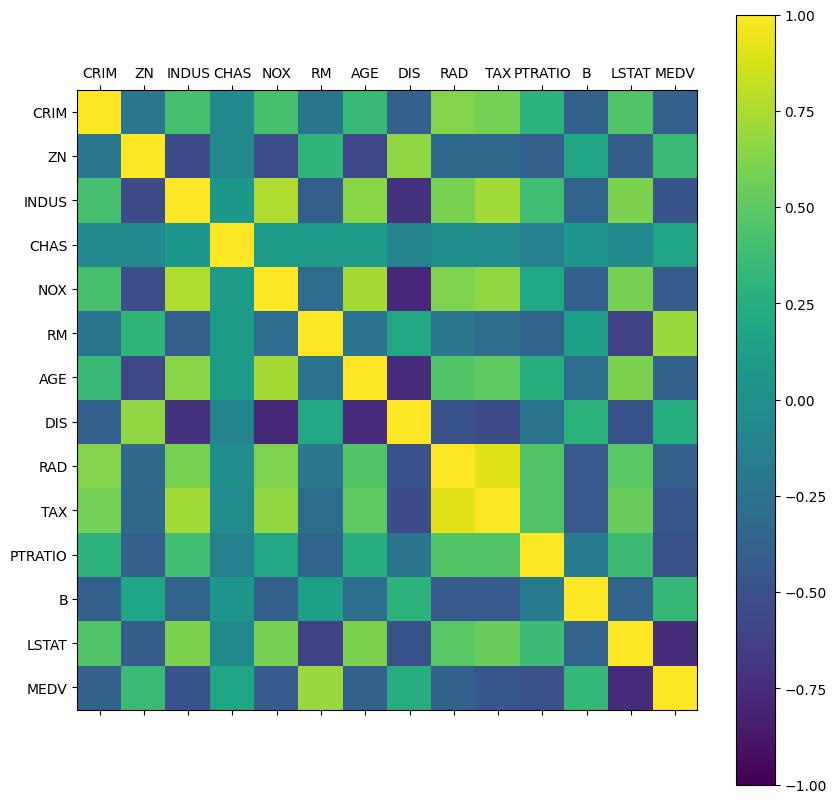

In [4]:
# Se plotea la matriz de correlacion
correlations = dataset.corr()
fig = plt.figure(figsize = [10, 10])
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, 14, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [5]:
correlations

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


#### Separar data en train y validación

In [6]:
# Separa el dataset en atributos (X) y target (y)
array = dataset.values
X = array[:, 0:13]  # Atributos
y = array[:, 13]    # Target

# Realiza el train-test split
test_size = 0.20  # Proporcion de muestras para validacion
seed = 7  # Semilla para el generador aleatorio (para reproductibilidad del problema)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed)

print('Training: %d ejemplos. Test: %d ejemplos' % (len(y_train), len(y_test)))

Training: 404 ejemplos. Test: 102 ejemplos


### Evalua diferentes algoritmos de ML en crossvalidación

No sabemos qué algoritmos de ML serán buenos para este problema o qué configuraciones usar.
Vamos a evaluar 7 algoritmos de ML diferentes:

    - Linear Regression (LinearReg)
    - Ridge Regression (Ridge)
    - Lasso Regression (Lasso)
    - Elastic Net Regression (ElasticNet)
    - KNN regression (KNN)
    - Regression Trees (RegTrees)

In [7]:
# Definimos el pool de algoritmos de ML a evaluar
algos = []
algos.append(('LinearReg', LinearRegression()))
algos.append(('Ridge', Ridge()))
algos.append(('Lasso', Lasso()))
algos.append(('ElasticNet', ElasticNet()))
algos.append(('KNN3', KNeighborsRegressor(n_neighbors = 3)))
algos.append(('KNN', KNeighborsRegressor(n_neighbors = 5)))
algos.append(('RegTrees', DecisionTreeRegressor()))

La evaluación de cada algoritmo se realiza con los datos de training en estrategia de crossvalidación con 10-folds. Se usa el mismo particionamiento de folds en cada algoritmo a evaluar para asegurar una comparación justa.

La métrica de evaluación es 'neg_mean_squared_error', esta es el negativo del error cuadrático medio (a mayor valor mejor).

In [8]:
# Evaluamos cada algoritmo de ML en estrategia de 10-fold-CV
results = []
names = []

# Genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7
kfold = KFold(n_splits = 10, random_state = seed, shuffle = True)  # Especifica el particionador de datos a 10-folds CV

# Evalua cada algoritmo
for algoname, algo in algos:
    cv_results = cross_val_score(algo, X_train, y_train, cv = kfold, scoring = 'neg_mean_squared_error')  # r2 neg_mean_squared_error
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))

LinearReg: -22.006008541988766 (12.188886010681346)
Ridge: -22.040492855443688 (12.550922726843828)
Lasso: -27.105803342288556 (13.165914704600763)
ElasticNet: -27.923013623389995 (13.156405425527131)
KNN3: -39.129616598915995 (12.729467018931036)
KNN: -39.808935902439025 (16.50796779686553)
RegTrees: -26.355268902439025 (17.545888864970014)


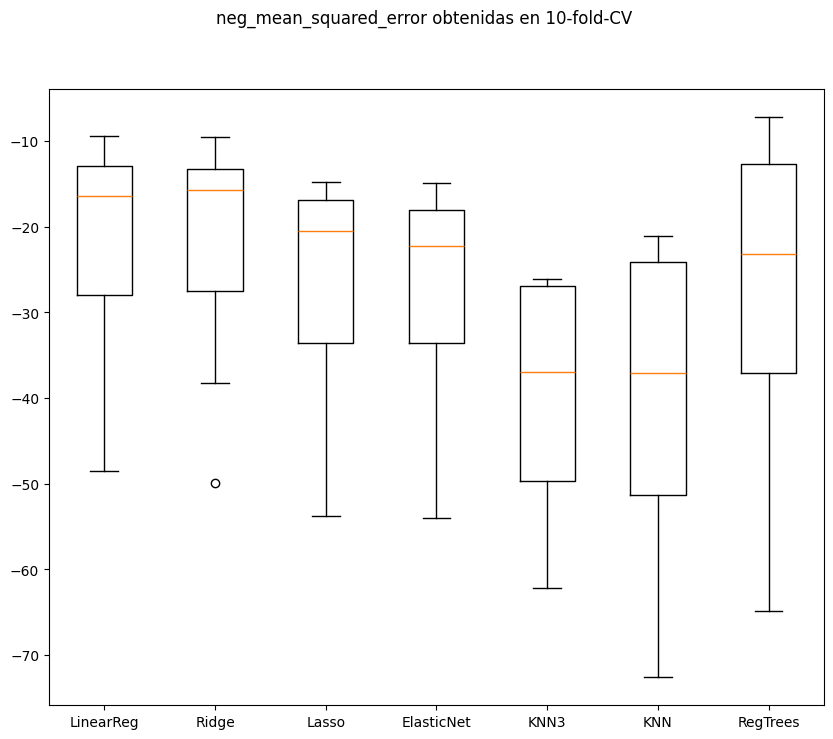

In [9]:
# Muestra graficamente los resultados de neg_mean_absolute_error en crossvalidación de los algoritmos evaluados
fig = plt.figure()
fig.suptitle('neg_mean_squared_error obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Entrenamiento del modelo con el algoritmo seleccionado y lo prueba en datos de validación

Ahora entrenaremos el modelo con el mejor algoritmo (Ridge Regresion) usando todos los datos de entrenamiento y lo evaluamos en la data separada para validación.

In [10]:
# Reentrena el modelo de regresion Ridge con todos los datos de entrenamiento y lo prueba en el conjunto de test
model = Ridge()  # Usar (class_weight = 'balanced') para entrenar tomando en cuenta el desbalance
model.fit(X_train, y_train)

# Predice el target en el conjunto de test
y_predicted = model.predict(X_test)
print("Mean squared error:", mean_squared_error(y_test, y_predicted))
print("Mean absolute error:", mean_absolute_error(y_test, y_predicted))
print("Explained variance score:", explained_variance_score(y_test, y_predicted))
print("R2 score:", r2_score(y_test, y_predicted))

Mean squared error: 34.71726900893568
Mean absolute error: 3.7762017186417562
Explained variance score: 0.5707370012765068
R2 score: 0.5703641157344463


#### Plotea los valores reales vs los predichos en el conjunto de validación

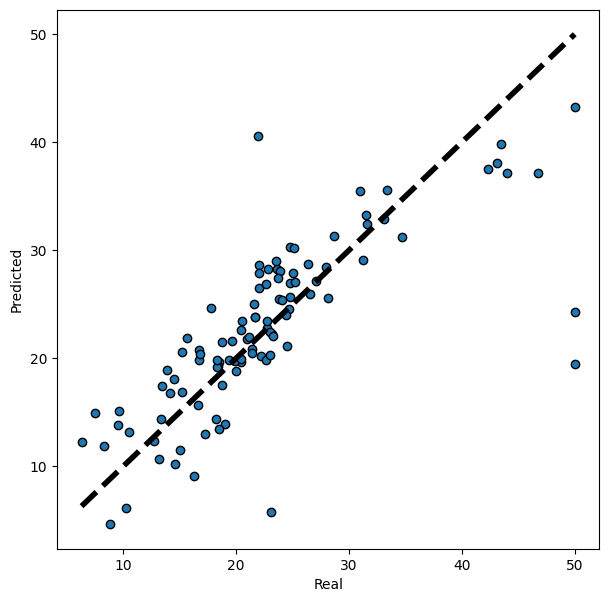

In [11]:
fig, ax = plt.subplots(figsize = [7, 7])
ax.scatter(y_test, y_predicted, edgecolors = (0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw = 4)
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.show()

In [12]:
# Obtiene los coeficientes del modelo
model.coef_

array([-1.23976583e-01,  3.16681081e-02, -8.24394560e-03,  2.76759821e+00,
       -8.36557661e+00,  5.33096386e+00, -1.71442530e-02, -1.17561646e+00,
        2.49912139e-01, -1.19942782e-02, -8.34872036e-01,  1.05525548e-02,
       -3.95625226e-01])

## Pipelines

Si se quiere usar tecnicas de pre-procesamiento (escalamiento, normalización, feature selection, feature transformation, etc) es importante que dichos procesos sean hechos en la estrategia de crossvalidación. No se debe hacer la transformación en todo el conjunto de datos disponible y luego aplicar la estrategia de crossvalidación para evaluar modelos porque se incurre en 'data leakage' y las métricas de evaluación serán mejores de lo real. En Sklearn se puede implementar <b> pipelines </b> para evaluar en crosvalidación todo el conjunto de pasos de pre-procesamiento y modelamiento.

Veamos el ejemplo anterior haciendo un escalamiento estándar en los atributos como parte del pipeline de modelamiento:

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

# Definimos el pool de pipelines de ML (escalador + algoritmo de ML) a evaluar
pipelines = []
pipelines.append(('pipLinearReg', make_pipeline(MinMaxScaler(), LinearRegression())))
pipelines.append(('pipRidge', make_pipeline(StandardScaler(), Ridge())))
pipelines.append(('pipLasso', make_pipeline(StandardScaler(), Lasso())))
pipelines.append(('pipElasticNet', make_pipeline(StandardScaler(), ElasticNet())))
pipelines.append(('pipKNN', make_pipeline(StandardScaler(), KNeighborsRegressor( ))))
pipelines.append(('pipRegTrees', make_pipeline(StandardScaler(), DecisionTreeRegressor())))
#pipelines.append(('pipPCA_RegTrees', make_pipeline(StandardScaler(), PCA(n_components = 5), KNeighborsRegressor())))

In [14]:
# Evaluamos cada pipeline de ML en estrategia de 10-fold-CV
results = []
names = []

# Genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7
kfold = KFold(n_splits = 10, random_state = seed, shuffle = True)  # Especifica el particionador de datos a 10-folds CV

# Evalua cada pipeline en crossvalidacion
for pipelinename, pipeline in pipelines:
    cv_results = cross_val_score(pipeline, X_train, y_train, cv = kfold, scoring = 'neg_mean_squared_error')
    results.append(cv_results)
    names.append(pipelinename)
    print("{}: {} ({})".format(pipelinename, cv_results.mean(), cv_results.std()))

pipLinearReg: -22.006008541988734 (12.188886010681196)
pipRidge: -21.988408595885403 (12.189610389336647)
pipLasso: -27.205895658130324 (12.124418229519785)
pipElasticNet: -28.30115970360337 (13.609109541638533)
pipKNN: -21.45686665853659 (15.016217766474995)
pipRegTrees: -27.7383737804878 (19.059972814099698)


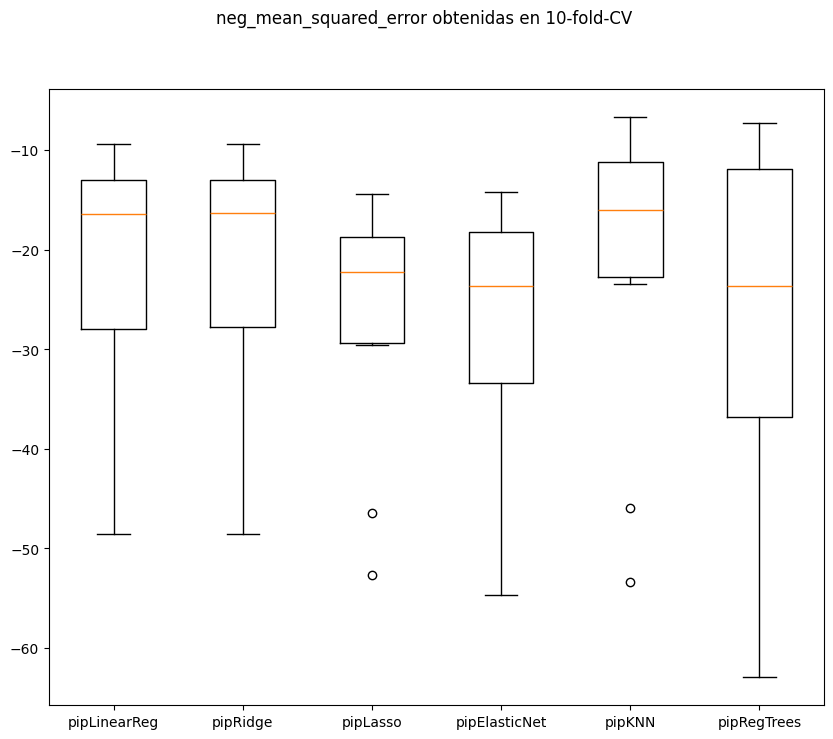

In [15]:
# Muestra graficamente los resultados de balanced_accuracy en crossvalidacion de los pipelines evaluados
fig = plt.figure()
fig.suptitle('neg_mean_squared_error obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Una vez identificado el pipeline con mejor desempeño entrenamos un modelo con dicho pipeline y toda la data de entrenamiento.

Mean squared error: 21.11325098039216
Mean absolute error: 2.913529411764706
Explained variance score: 0.7435866695884885
R2 score: 0.7387176320710418


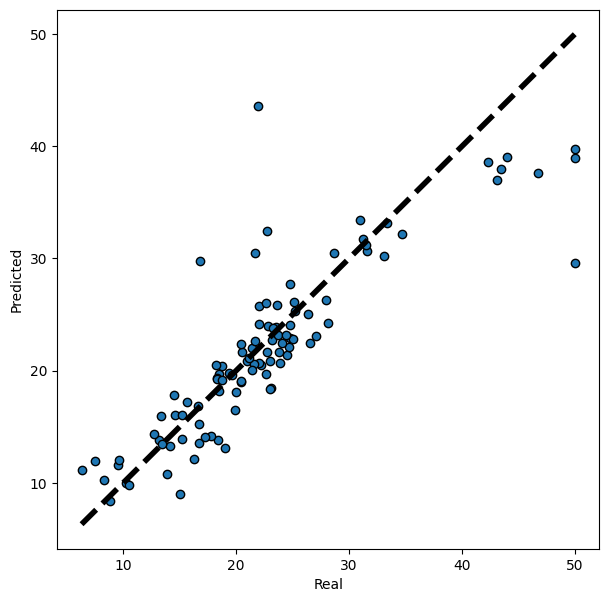

In [16]:
# Reentrena el pipeline con todos los datos de entrenamiento y lo prueba en el conjunto de validación
pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor())
pipeline.fit(X_train, y_train)

# Predice el target en el conjunto de validacion
y_predicted = pipeline.predict(X_test)
print("Mean squared error:", mean_squared_error(y_test, y_predicted))
print("Mean absolute error:", mean_absolute_error(y_test, y_predicted))
print("Explained variance score:", explained_variance_score(y_test, y_predicted))
print("R2 score:", r2_score(y_test, y_predicted))

# Plotea los valores reales vs los predichos en el conjunto de validacion
fig, ax = plt.subplots(figsize = [7, 7])
ax.scatter(y_test, y_predicted, edgecolors = (0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw = 4)
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.show()

In [17]:
# Note que el resultado del ajuste es un Pipeline
pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor())])

In [18]:
# Veamos como accedemos al modelo de un pipeline con un scaler + Lasso:
pipeline = make_pipeline(StandardScaler(), Lasso())
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())])

In [19]:
# Obtiene el modelo ajustado Lasso
modeloLasso = pipeline.steps[1][1]

# Imprime los coeficientes aprendidos del modelo
modeloLasso.coef_

array([-0.        ,  0.        , -0.        ,  0.12999372, -0.        ,
        3.53957244, -0.        , -0.        , -0.        , -0.24549078,
       -1.21948143,  0.16472854, -2.89083826])